In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
import torchvision.models as models

In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [5]:
# Define the folder containing your images
fakeImage_folder = r'E:\DeepFake\DeepFake\Dataset\Fake'
realImage_folder = r'E:\DeepFake\DeepFake\Dataset\Real'

# List all image files in the folder
fakeImage_files = [os.path.join(fakeImage_folder, file) for file in os.listdir(fakeImage_folder) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
realImage_files = [os.path.join(realImage_folder, file) for file in os.listdir(realImage_folder) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

fake_df = pd.DataFrame(columns=['Image_Path', 'Fake'])

fake_df['Image_Path'] = fakeImage_files
fake_df['Fake'] = 1

real_df = pd.DataFrame(columns=['Image_Path', 'Fake'])
real_df['Image_Path'] = realImage_files
real_df['Fake'] = 0

result_df = pd.concat([fake_df[:70000], real_df])

In [6]:
# Split the data into a training set and a test set (50% each) with class balance
X_train, X_test, y_train, y_test = train_test_split(result_df['Image_Path'], result_df['Fake'], test_size=0.9, stratify= result_df['Fake'], random_state=35)

In [7]:
class ImageModel(nn.Module):
    def __init__(self, num_classes):
        super(ImageModel, self).__init__()
        model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.3)
        self.linear1 = nn.Linear(2048, num_classes)

    def forward(self, x):
        batch_size, c, h, w = x.shape
        x = x.view(batch_size, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, 2048)
        x = self.relu(x)
        x = self.dp(x)
        x = self.linear1(x)
        return fmap, x

In [8]:
# Step 2: Instantiate the Model
num_classes = 2  # Assuming 2 classes for "fake" and "not fake"
image_model = ImageModel(num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_model = image_model.to(device)

# Step 3: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_model.parameters(), lr=0.001)

In [9]:
# Step 4: Training Loop
num_epochs = 1000
batch_size = 16

In [10]:
class FaceDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
transform = transforms.Compose([ transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [12]:
train_dataset = FaceDataset(X_train.values, y_train.values, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = FaceDataset(X_test.values, y_test.values, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [23]:
for epoch in range(num_epochs):
    image_model.train()  # Set the model to training mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward 
        _, predictions = image_model(inputs)
        loss = criterion(predictions, labels)

        # Backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accuracy and loss
        _, predicted = torch.max(predictions, 1)
        correct += (predicted == labels).sum().item()
        tt_samples += labels.size(0)
        tt_loss += loss.item()

    
    avg_loss = tt_loss / len(train_loader)
    acc = correct / tt_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], \
          Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}')

    model_path = 'model/lstm_model' + str(epoch) + '_' + str(average_loss) + "_" + str(accuracy) +'.pth'
    print('saving model name:',model_path)
    torch.save(image_model.state_dict(),model_path)

Epoch [1/1000], Loss: 0.0752, Accuracy: 0.9723
saving model name: model/lstm_model0_0.07518834999802389_0.9722857142857143.pth
Epoch [2/1000], Loss: 0.0683, Accuracy: 0.9758
saving model name: model/lstm_model1_0.0683150559988405_0.9757857142857143.pth
Epoch [3/1000], Loss: 0.0544, Accuracy: 0.9814
saving model name: model/lstm_model2_0.054421115392839836_0.9813571428571428.pth
Epoch [4/1000], Loss: 0.0444, Accuracy: 0.9829
saving model name: model/lstm_model3_0.04440889281055674_0.9828571428571429.pth
Epoch [5/1000], Loss: 0.0467, Accuracy: 0.9833
saving model name: model/lstm_model4_0.04673616900467771_0.9832857142857143.pth
Epoch [6/1000], Loss: 0.0396, Accuracy: 0.9864
saving model name: model/lstm_model5_0.03955414512795479_0.9864285714285714.pth
Epoch [7/1000], Loss: 0.0295, Accuracy: 0.9892
saving model name: model/lstm_model6_0.029510079270461672_0.9892142857142857.pth
Epoch [8/1000], Loss: 0.0274, Accuracy: 0.9898
saving model name: model/lstm_model7_0.02736789979094257_0.9897

KeyboardInterrupt: 

In [47]:
# Load model
model = ImageModel(num_classes=2)
model.load_state_dict(torch.load("model/lstm_model7_0.02736789979094257_0.9897857142857143.pth"))
model = model.to(device)

In [48]:
test_dataset = FaceDataset(X_test[:14000].values, y_test[:14000].values, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [49]:
model.eval()
allLabels = []
allPredictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        _, outputs = model(inputs)

        # Assuming outputs[:, 1] is the probability of being in class 1
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

        allLabels.extend(labels.cpu().numpy())
        allPredictions.extend(predictions)

accuracy = accuracy_score(allLabels, allPredictions)
precision = precision_score(allLabels, allPredictions)
recall = recall_score(allLabels, allPredictions)
f1 = f1_score(allLabels, allPredictions)

In [57]:
# Assuming outputs[:, 1] is the probability of being in class 1 (for AUC-ROC)
auc_roc = roc_auc_score(allLabels, allPredictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.9803
Precision: 0.9695
Recall: 0.9921
F1 Score: 0.9806
AUC-ROC: 0.9802


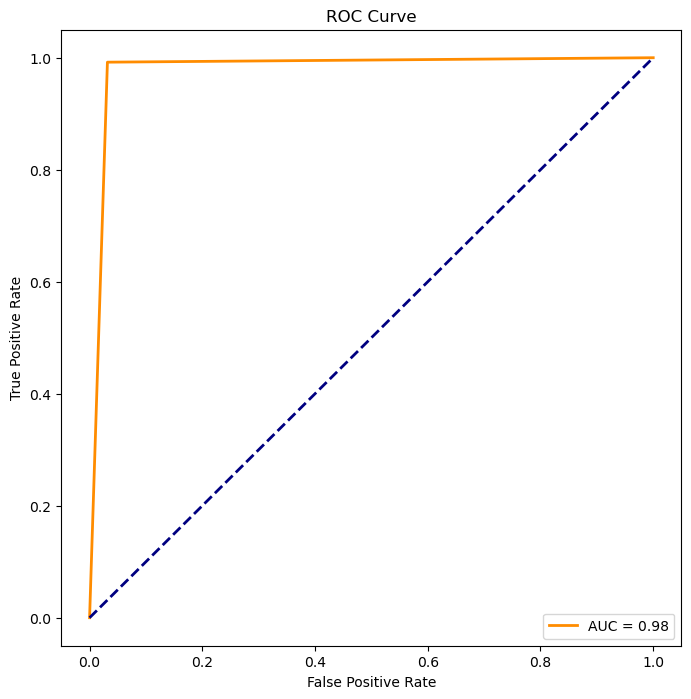

In [58]:
fpr, tpr, thresholds = roc_curve(allLabels, allPredictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()